In [8]:
import importlib, os, gc, sys
import SXBQ as sx
# ''
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, fmin
from scipy.signal import convolve as conv
import gsw
import cmocean.cm as cmo
from datetime import datetime as dt
import matplotlib.dates as mdates
import math

import matplotlib.colors as cl
from gsw import z_from_p, p_from_z, distance, SA_from_SP, CT_from_t, rho, distance, cp_t_exact


from scipy.signal import find_peaks
from scipy.stats import linregress


from matplotlib.gridspec import GridSpec

import glidertools as gt
import matplotlib.colors as colors
import matplotlib.cm as cm

from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

import seaborn as sns
sns.set(    rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'white',
         'axes.grid': False,
         'axes.labelcolor': 'k',
            
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1.6)

import warnings
warnings.filterwarnings('ignore')

def interp(x,y,xi):
    _gg = np.isfinite(x+y)
    return interp1d(x[_gg], y[_gg], bounds_error=False, fill_value=np.NaN)(xi)

# TRANSFORMATION ARGO vs GLIDER

In [4]:
glider_trans=xr.open_dataset('/home/jupyter-estelfont/3_MW_budget/data/WMT_sg079_2dt_0.1_0.05.nc')
glider_trans['G_si']=glider_trans.G_si.where(glider_trans.G_si!=0, np.nan)
glider_trans['G_ti']=glider_trans.G_ti.where(glider_trans.G_ti!=0, np.nan)
    
argo_trans=xr.open_dataset('/home/jupyter-estelfont/3_MW_budget/data/Argo_bymonth_WMT_01_0.05.nc')
argo_transMEAN=xr.open_dataset('/home/jupyter-estelfont/3_MW_budget/data/ArgoAPRILJULY_WMT_01_0.05.nc').isel(time_mid=0)

In [1]:
# glider_trans.lsq_relative_residual.mean(), argo_transMEAN.lsq_relative_residual.mean(), 

In [5]:
from matplotlib.colors import LinearSegmentedColormap
def get_cmap():
    """
    Create and return a custom colormap for visualizations.

    This function generates a linear segmented colormap that transitions through a specified 
    set of colors, ordered from dark red to dark blue. The colormap is defined using 
    hexadecimal color codes and is intended for use in visualizations where a smooth 
    transition between these colors is desired.

    Returns
    -------
    cmap : matplotlib.colors.LinearSegmentedColormap
        A custom colormap object that can be used in plotting functions to map data values 
        to colors.

    Notes
    -----
    - The colormap transitions through the following colors (in reverse order for the final colormap):
      '#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0', '#f7f7f7', 
      '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'.
    - The resulting colormap can be applied to any data visualization that supports colormaps, 
      such as those created with matplotlib.
    
    Example
    -------
    >>> cmap = get_cmap()
    >>> plt.imshow(data, cmap=cmap)
    >>> plt.colorbar()
    """
    
    # Define the colors in the order you've specified
    colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#f7f7f7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
    # Create a colormap that transitions from the first color to the last
    cmap_name = 'custom_cmap'
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors[::-1])
    return cmap

br=get_cmap()
dS, dT=0.1,0.05

## SUBSAMPLING

In [6]:
# Example data (replace this with your actual dataset)
G_si_T = glider_trans.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).G_si.T  
G_ti_T = glider_trans.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).G_ti.T  

def split_data(data, n):
    """Splits data into n interleaved subsets."""
    subsets = [data[i::n] for i in range(n)]
    return subsets

# Generate subsets dynamically
s_subsets_3d = split_data(G_si_T, 1)
s_subsets_6d = split_data(G_si_T, 2)
s_subsets_9d = split_data(G_si_T, 3)
s_subsets_12d = split_data(G_si_T, 4)
s_subsets_15d = split_data(G_si_T, 5)
s_subsets_18d = split_data(G_si_T, 6)
s_subsets_21d = split_data(G_si_T, 7)
s_subsets_25d = split_data(G_si_T, 8)
s_subsets_28d = split_data(G_si_T, 9)
s_subsets_30d = split_data(G_si_T, 10)


# Generate subsets dynamically
t_subsets_3d = split_data(G_ti_T, 1)
t_subsets_6d = split_data(G_ti_T, 2)
t_subsets_9d = split_data(G_ti_T, 3)
t_subsets_12d = split_data(G_ti_T, 4)
t_subsets_15d = split_data(G_ti_T, 5)
t_subsets_18d = split_data(G_ti_T, 6)
t_subsets_21d = split_data(G_ti_T, 7)
t_subsets_25d = split_data(G_ti_T, 8)
t_subsets_28d = split_data(G_ti_T, 9)
t_subsets_30d = split_data(G_ti_T, 10)


# Define the mapping of x-values to subset lists and their respective counts
s_subset_dict = {
    3: (s_subsets_3d, 1),
    6: (s_subsets_6d, 2),
    9: (s_subsets_9d, 3),
    12: (s_subsets_12d, 4),
    15: (s_subsets_15d, 5),
    18: (s_subsets_18d, 6),
    21: (s_subsets_21d, 7),
    24: (s_subsets_25d, 8),
    27: (s_subsets_28d, 9),
    30: (s_subsets_30d, 10)
    }

t_subset_dict = {
    3: (t_subsets_3d, 1),
    6: (t_subsets_6d, 2),
    9: (t_subsets_9d, 3),
    12: (t_subsets_12d, 4),
    15: (t_subsets_15d, 5),
    18: (t_subsets_18d, 6),
    21: (t_subsets_21d, 7),
    24: (t_subsets_25d, 8),
    27: (t_subsets_28d, 9),
    30: (t_subsets_30d, 10)
}

## GRIDDING

In [31]:
ds=xr.open_dataset('/home/jupyter-estelfont/datasets/argo/ModeWater_SoO/gridded_along_across_SoO_per_month.nc')
ds_climat=ds.copy()

In [10]:
ds_79=xr.open_dataset('/home/jupyter-estelfont/datasets/glider_grid/sg79_gridded_pp_pressure.nc')
ds2_=xr.open_dataset('/home/jupyter-estelfont/3_MW_budget/data/sea079_by_transect.nc')
        
def data_grid_roll(DS, climat_or_transect, month, var): # month, cons_temp, abs_salinity ,  potential_density , spice
    if climat_or_transect=='month':
        get_section1=DS.groupby('t.month')[month]
        def roll(ds):
            ds = pd.DataFrame(ds).interpolate(limit=5,axis=0).interpolate(limit=2,axis=1).rolling(5,axis=0, center=True).mean().rolling(10,axis=1, center=True).mean()
            return ds.to_numpy()
        dx, dy=1, 1
        xaxis=np.arange(0,80+dx,dx)
        yaxis=np.arange(0,500+dy,dy)

    elif climat_or_transect=='transect':
        get_section1=ds2_.sel(transect_number=month).where(ds2_.sel(transect_number=month).cons_temp.count('pressure')!=0, drop=True)
        def roll(ds):
            # ds = pd.DataFrame(ds).interpolate(limit=5,axis=0).interpolate(limit=2,axis=1).rolling(5,axis=0, center=True).mean().rolling(5,axis=1, center=True).mean()
            ds = pd.DataFrame(ds).interpolate(limit=2,axis=1).rolling(3,axis=1, center=True).mean()
            
            return ds.to_numpy()
        dx, dy=2, 0.5
        xaxis=np.arange(0,80+dx,dx)
        yaxis=np.arange(0,500+dy,dy)

    XX1, YY1=np.meshgrid(get_section1.distance_bin_on_transect,  get_section1.pressure)
    ct1, _ ,_=sx.grid2d(XX1.flatten(), YY1.flatten(), get_section1[var].values.flatten(), xi=xaxis, yi=yaxis, fn='mean')
    
    return roll(ct1)[:, int(10/dx):int(-7/dx)]

# dataset='climat'
dataset='glider'

if dataset=='glider':
    dx, dy=2, 0.5
climat_or_transect='transect'

sigma_, spice_, o2_, aou_=[], [], [], []
for ii in tqdm(range(5,24)):
    sigma_.append(data_grid_roll(ds_79, climat_or_transect, ii, 'potential_density'))
    spice_.append(data_grid_roll(ds_79, climat_or_transect, ii, 'spice'))
    o2_.append(data_grid_roll(ds_79, climat_or_transect, ii, 'oxygen_concentration'))    
    aou_.append(data_grid_roll(ds_79, climat_or_transect, ii, 'aou'))        
    
    
    
xaxis=np.arange(0,80+dx,dx)[int(10/dx):int(-7/dx)]
yaxis=np.arange(0,500+dy,dy)
    
ds_grided_pertransect = xr.Dataset({},    coords={'x': xaxis,'y': yaxis, 'time': pd.to_datetime(ds2_.time.mean(['pressure', 'profile_number']).values)[5:] })
ds_grided_pertransect['sigma']=(('time', 'y', 'x'), sigma_)
ds_grided_pertransect['spice']=(('time', 'y', 'x'), spice_)
ds_grided_pertransect['oxygen_concentration']=(('time', 'y', 'x'), o2_)
ds_grided_pertransect['aou']=(('time', 'y', 'x'), aou_)



mean_sigpertrans=ds_grided_pertransect.where((ds_grided_pertransect.sigma>25) & (ds_grided_pertransect.sigma<25.25)).sigma.mean(['y', 'x'])
mean_spicepertrans=ds_grided_pertransect.where((ds_grided_pertransect.sigma>25) & (ds_grided_pertransect.sigma<25.25)).spice.mean(['y', 'x'])
mean_o2pertrans=ds_grided_pertransect.where((ds_grided_pertransect.sigma>25) & (ds_grided_pertransect.sigma<25.25)).oxygen_concentration.mean(['y', 'x'])

  0%|          | 0/19 [00:00<?, ?it/s]

## PLOT FIGURE 2

In [12]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
from matplotlib import font_manager

c_isopyc='#558C8C'
c_diapy='#963D5A'

fntsize=20


def get_cmap(n_bins=10):
    """
    Create and return a discrete custom colormap for visualizations.

    Parameters
    ----------
    n_bins : int
        Number of discrete color bins in the final colormap.

    Returns
    -------
    cmap : matplotlib.colors.ListedColormap
        A custom discrete colormap object with `n_bins` levels.
    """
    # Define the colors from dark red to dark blue
    colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7',
              '#f7f7f7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']

    # Create a continuous colormap first
    cmap_continuous = LinearSegmentedColormap.from_list('custom_cmap', colors[::-1])

    # Sample n_bins colors from the continuous colormap
    sampled_colors = cmap_continuous(np.linspace(0, 1, n_bins))

    # Return a discrete ListedColormap
    return ListedColormap(sampled_colors, name='custom_cmap_10')

# Usage
br = get_cmap()


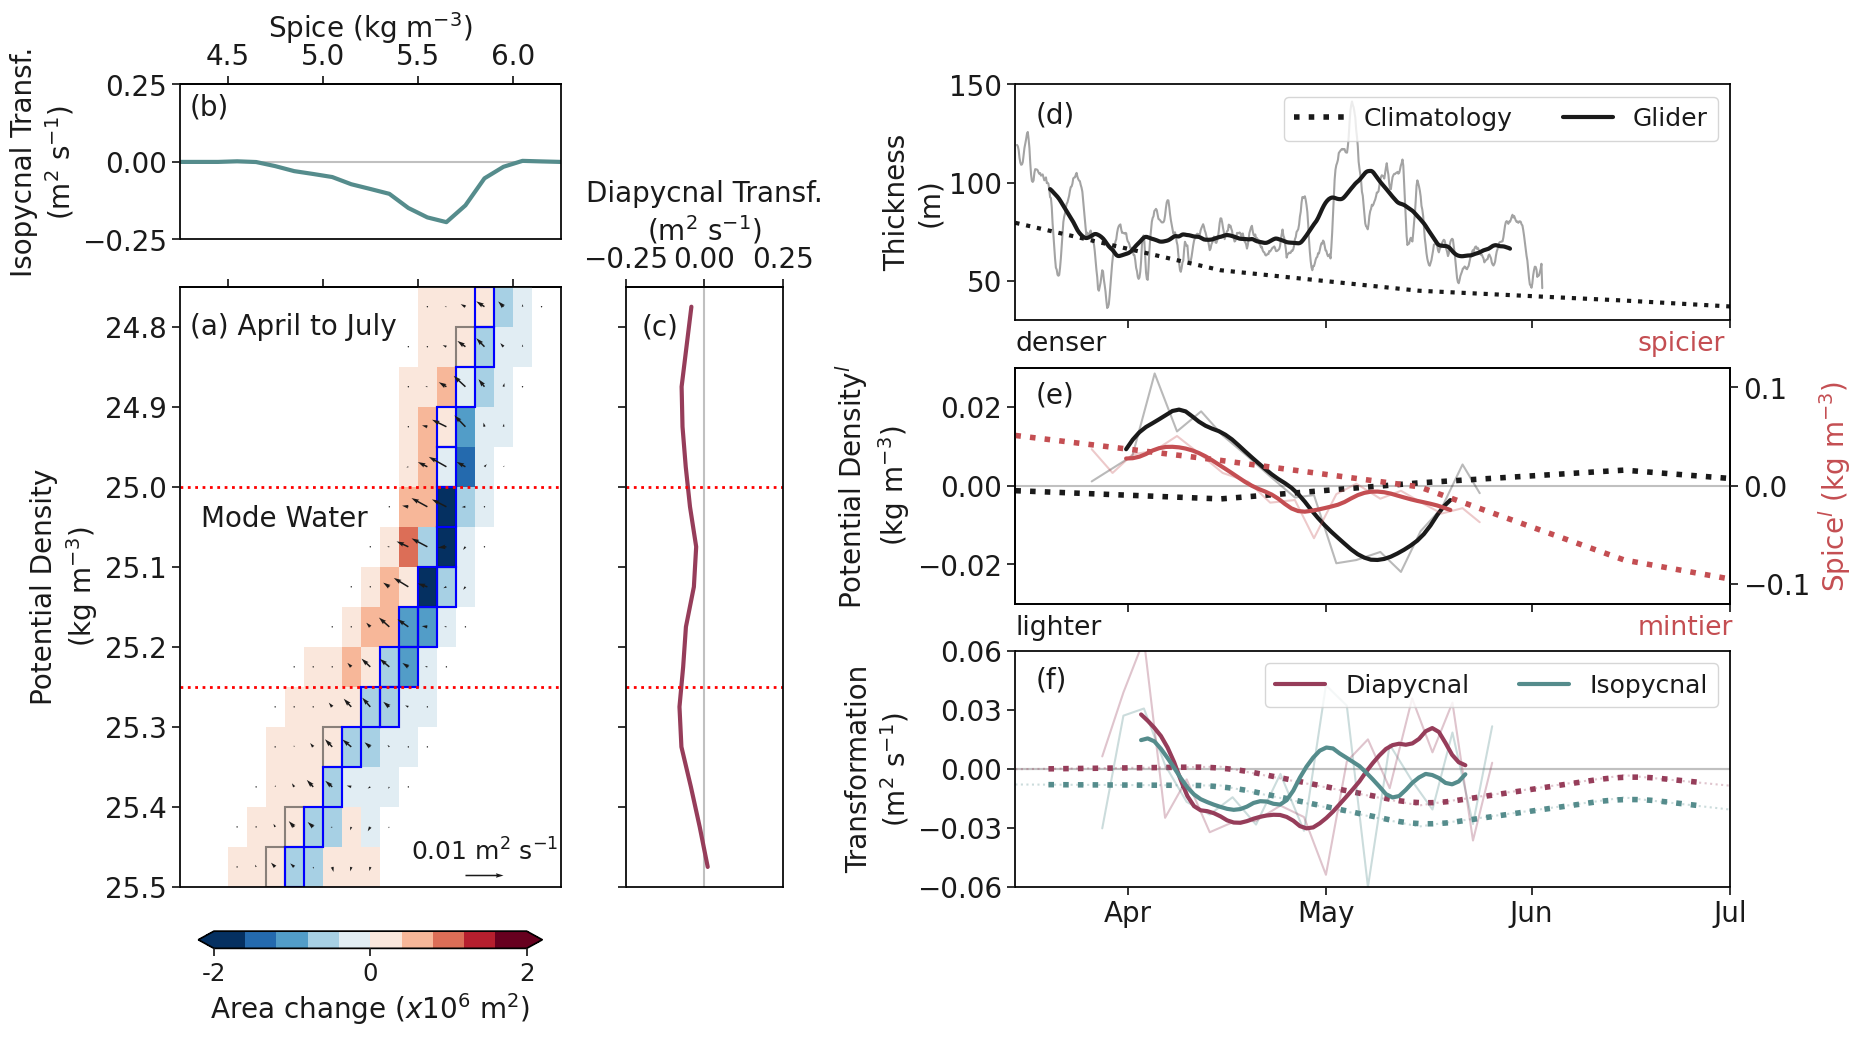

In [36]:
ff = plt.figure(constrained_layout=True, figsize=(20, 12))
spec2 = GridSpec(ncols=28, nrows=23, figure=ff)

ax1 = ff.add_subplot(spec2[5:20, 0:7])
cc=plt.pcolormesh(argo_transMEAN.S_bini,  argo_transMEAN.T_bini, argo_transMEAN.dvol_G, cmap=br, vmin=-2000000, vmax=2000000)
q=plt.quiver(argo_transMEAN.S_bini,  argo_transMEAN.T_bini, argo_transMEAN.G_si, -argo_transMEAN.G_ti, angles='uv', color='k', scale=1, zorder=10, width=0.004)
plt.quiverkey(q, X=0.8, Y=0.02, U=0.1,
              label='0.01 m$^{2}$ s$^{-1}$', labelpos='N',
              coordinates='axes' , fontproperties=font_manager.FontProperties(size=fntsize-2))
plt.ylim(25.5, 24.75)
plt.xlim(4.25, 6.25)
plt.axhline(25, c='red', ls=':', lw=2)
plt.axhline(25.25,  c='red', ls=':', lw=2)
plt.text(4.3, 24.81, s='(a) April to July', fontsize=fntsize)
plt.text(4.8, 25.05, s='Mode Water', fontsize=fntsize, ha='center')
ax1.tick_params(axis='both', labelsize=fntsize)
plt.ylabel('Potential Density\n(kg m$^{-3}$)', fontsize=fntsize)
ax1.tick_params(axis='x', bottom=False, labelbottom=False)
ax_top = ax1.secondary_xaxis('top')
ax_top.set_xticklabels([])

dsS_=(np.abs(argo_transMEAN.epsilon)*100/(np.abs(argo_transMEAN.dvol_G)+np.abs(argo_transMEAN.epsilon))>0).astype(float).sel(T_bini=slice(24.75, 25.5)).sel(S_bini=slice(4.7, 6.3))
for i_ in range(dsS_.shape[0]):
    for j_ in range(dsS_.shape[1]):
        if dsS_[i_, j_] == 1:
            plt.gca().add_patch(plt.Rectangle((dsS_.S_bini[j_]-dS/2, dsS_.T_bini[i_]-dT/2), dS, dT, fill=False, edgecolor="k", linewidth=1.5, alpha=0.5))            
        
dsS_=(np.abs(argo_transMEAN.epsilon)*100/(np.abs(argo_transMEAN.dvol_G)+np.abs(argo_transMEAN.epsilon))>25).astype(float).sel(T_bini=slice(24.75, 25.5)).sel(S_bini=slice(4.7, 6.3))
neg=dsS_*(-1*(argo_transMEAN.epsilon.sel(T_bini=slice(24.75, 25.5)).sel(S_bini=slice(4.7, 6.3))<0).astype(float))
pos=dsS_*((argo_transMEAN.epsilon.sel(T_bini=slice(24.75, 25.5)).sel(S_bini=slice(4.7, 6.3))>0).astype(float))    # dsS_=ts_trans.epsilon.where(~np.isfinite(ts_trans.epsilon), 1).where(np.isfinite(ts_trans.epsilon), 0).sel(T_bini=slice(24.9, 25.3)).sel(S_bini=slice(4.7, 6.3))    

dsS_=neg+pos
for i_ in range(dsS_.shape[0]):
    for j_ in range(dsS_.shape[1]):
        if dsS_[i_, j_] == 1:
            plt.gca().add_patch(plt.Rectangle((dsS_.S_bini[j_]-dS/2, dsS_.T_bini[i_]-dT/2), dS, dT, fill=False, edgecolor="red", linewidth=1.5))            
        if dsS_[i_, j_] == -1:
            plt.gca().add_patch(plt.Rectangle((dsS_.S_bini[j_]-dS/2, dsS_.T_bini[i_]-dT/2), dS, dT, fill=False, edgecolor="blue", linewidth=1.5))            
ax1.tick_params(axis='x', which='both', labelbottom=False)


ax1bot = ff.add_subplot(spec2[0:4, :7])

ax1bot.set_ylabel('Isopycnal Transf.\n(m$^{2}$ s$^{-1}$)', fontsize=fntsize)
plt.plot(argo_transMEAN.S_bini.sel(S_bini=slice(4, 6.5)),  argo_transMEAN.G_si.sel(T_bini=slice(24.75, 25.5)).sel(S_bini=slice(4, 6.5)).sum(dim='T_bini'), c=c_isopyc, lw=3)
plt.xlim(4.25, 6.25)
plt.axhline(0, c='silver', zorder=-10)
plt.ylim(-0.25, 0.25)
plt.yticks([-0.25,0, 0.25])
ax1bot.tick_params(axis='both', labelsize=fntsize)
plt.text(4.3, 0.15, s='(b)', fontsize=fntsize)
# plt.xlabel('Spice (kg m$^{-3}$)')
ax1bot.tick_params(axis='x', bottom=False, labelbottom=False)
ax_top = ax1bot.secondary_xaxis('top')
ax_top.set_xlabel('Spice (kg m$^{-3}$)', fontsize=fntsize)
ax_top.tick_params(axis='both', labelsize=fntsize)


ax1righ = ff.add_subplot(spec2[5:20, 8:11])

plt.ylim(25.5, 24.75)
plt.plot(argo_transMEAN.G_ti.sel(S_bini=slice(4, 6.5)).sel(T_bini=slice(24.75, 25.5)).sum(dim='S_bini'), argo_transMEAN.T_bini.sel(T_bini=slice(24.75, 25.5)) , lw=3,c=c_diapy)
plt.axvline(0, c='silver', zorder=-10)
plt.xlim(-0.25, 0.25)
plt.gca().tick_params(axis='y', which='both', labelleft=False)
ax1righ.tick_params(axis='x', bottom=False, labelbottom=False)
ax_top = ax1righ.secondary_xaxis('top')
ax_top.set_xlabel('Diapycnal Transf.\n(m$^{2}$ s$^{-1}$)', fontsize=fntsize)
plt.xticks([-0.25,0, 0.25])
ax_top.tick_params(axis='both', labelsize=fntsize)
plt.text( -0.2, 24.81, s='(c)', fontsize=fntsize)
plt.axhline(25, c='red', ls=':', lw=2)
plt.axhline(25.25,  c='red', ls=':', lw=2)
# plt.gca().tick_params(axis='both', labelsize=fntsize)

# cb.ax.set_position([0.1, 0.9, 0.5, 0.01]) 
# cb.set_label('Area change (m$^{2}$)')
# cb.ax.xaxis.set_label_position('top')
# cb.ax.xaxis.set_ticks_position('top')
# , ax=ax1, pad=-1.23, shrink=0.7, extend='both'

##########
ax2aa = ff.add_subplot(spec2[0:6, 15:])
ax2aa.tick_params(axis='x', which='both', labelbottom=False)
plt.ylabel('Thickness\n(m)', fontsize=fntsize)  
ds_79_tid=xr.open_dataset('/home/jupyter-estelfont/datasets/glider_grid/sg79_gridded_time_pressure.nc').sel(time=slice('2015-03-15', '2015-07-01'))
plt.axhline(0, c='silver')
plt.ylim(30,150)
lol_0=(~np.isnan(ds_climat['sigma_across'].where(ds_climat['sigma_across']<25.25, np.nan).where(ds_climat['sigma_across']>24.95, np.nan).astype(float))).astype(float).sum('pressure')
lol_1=lol_0.where(lol_0!=0, np.nan)
lol1_=lol_1.mean('distance').sel(month=slice(3,9))
plt.plot(argo_trans.time_mid, lol1_    , c='k', ls=':', lw=3)

lol_=pd.DataFrame((~np.isnan(ds_79_tid['potential_density'].where(ds_79_tid['potential_density']<25.25, np.nan).where(ds_79_tid['potential_density']>24.95, np.nan).astype(float))).astype(float).sum(axis=0)*0.5).rolling(5, center=True).mean() # -np.nanmean(pd.DataFrame((~np.isnan(ds_79_tid['potential_density'].where(ds_79_tid['potential_density']<25.25, np.nan).where(ds_79_tid['potential_density']>24.95, np.nan).astype(float))).astype(float).sum(axis=0)*0.5).rolling(5, center=True).mean())    
plt.plot(ds_79_tid.time, lol_   ,      c='k', alpha=0.4,)
plt.plot(ds_79_tid.time, lol_.rolling(80, center=True).mean()   ,    c='k', ls='-', lw=3)

plt.plot([0,0], [1,1], lw=4, c='k', ls=':', label='Climatology')
plt.plot([0,0], [1,1], lw=3, c='k', label='Glider')
plt.legend(ncol=2, loc=1, fontsize=fntsize-2)

plt.xlim(pd.to_datetime('2015-03-15'), pd.to_datetime('2015-07-01'))
ax2aa.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax2aa.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax2aa.tick_params(axis='both', labelsize=fntsize)
plt.text(pd.to_datetime('2015-03-18'), 130, s='(d)', fontsize=fntsize)

ax2a = ff.add_subplot(spec2[7:13, 15:])
plt.ylabel('Potential Density$^{l}$ \n(kg m$^{-3}$)', fontsize=fntsize)  
ax2a.tick_params(axis='x', which='both', labelbottom=False)

plt.text(pd.to_datetime('2015-03-15'), 0.036,  'denser',va='center' )
plt.text(pd.to_datetime('2015-03-15'), -0.036, 'lighter', va='center' )

plt.text(pd.to_datetime('2015-06-17'), 0.036,  'spicier', c='r',va='center' )
plt.text(pd.to_datetime('2015-06-17'), -0.036, 'mintier', c='r',va='center' )
plt.ylim(-0.03,0.03)
plt.axhline(0, c='silver')

# glidertimeseriesdens=ds_79_tid['potential_density'].where(ds_79_tid['potential_density']<25.25, np.nan).where(ds_79_tid['potential_density']>24.95, np.nan).median(['pressure']).rolling(time=50, center=True).mean()
# plt.plot(glidertimeseriesdens.time, glidertimeseriesdens-glidertimeseriesdens.mean(), c='silver')

# density_ranges = [ (25, 25.25, 'k', 'mid')]
mean_sigpertrans=ds_grided_pertransect.where((ds_grided_pertransect.sigma>25) & (ds_grided_pertransect.sigma<25.25)).sigma.mean(['y', 'x'])
mean_spicepertrans=ds_grided_pertransect.where((ds_grided_pertransect.sigma>25) & (ds_grided_pertransect.sigma<25.25)).spice.mean(['y', 'x'])
time_Shift=pd.Timedelta(np.nanmean(glider_trans.delta_time), unit='s')

plt.plot(mean_spicepertrans.time-time_Shift, mean_sigpertrans-np.nanmean(mean_sigpertrans), c='k', alpha=0.3)
new_time = pd.date_range(start=pd.to_datetime('2015-03-15'), 
                             end=pd.to_datetime('2015-07-01'), 
                             freq='1D')  # Hourly frequency
rolling_s = ( mean_sigpertrans-np.nanmean(mean_sigpertrans)).interp(time=new_time)
plt.plot(rolling_s.time-time_Shift, rolling_s.rolling(time=10, center=True).mean(), c='k', lw=3)
dens_change_Argo=ds_climat.where((ds_climat.sigma_across>25) & (ds_climat.sigma_across<25.25)).sigma_across.mean(['distance', 'pressure']).sel(month=slice(3,9))
plt.plot(argo_trans.time_mid, dens_change_Argo-dens_change_Argo.sel(month=slice(3,6)).mean(), c='k', ls=':', lw=4)
plt.text(pd.to_datetime('2015-03-18'), 0.021, s='(e)', fontsize=fntsize)
plt.gca().tick_params(axis='both', labelsize=fntsize)


ax2a.twinx()
density_ranges = [ (25, 25.25, 'r', 'mid')]
plt.ylabel('Spice$^{l}$ (kg m$^{-3}$)', c='r', fontsize=fntsize)
plt.ylim(-0.12,0.12)
plt.xlim(pd.to_datetime('2015-03-15'), pd.to_datetime('2015-07-01'))
ax2a.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax2a.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

spice_change_Argo=ds_climat.where((ds_climat.sigma_across>25) & (ds_climat.sigma_across<25.25)).spice_across.mean(['distance', 'pressure']).sel(month=slice(3,9))
plt.plot(argo_trans.time_mid, spice_change_Argo-spice_change_Argo.sel(month=slice(3,6)).mean(), c='r', ls=':', lw=4)

plt.plot(mean_spicepertrans.time-time_Shift, mean_spicepertrans-np.nanmean(mean_spicepertrans), c='r', alpha=0.3)
new_time = pd.date_range(start=pd.to_datetime('2015-03-15'), 
                             end=pd.to_datetime('2015-07-01'), 
                             freq='1D')  # Hourly frequency
rolling_s = (mean_spicepertrans-np.nanmean(mean_spicepertrans)).interp(time=new_time)
plt.plot(rolling_s.time-time_Shift, rolling_s.rolling(time=10, center=True).mean(), c='r', lw=3)
plt.gca().tick_params(axis='both', labelsize=fntsize)


ax3 = ff.add_subplot(spec2[14:20, 15:])

plt.axhline(0, c='silver')
isopt=argo_trans.G_si.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini'])
diapt=argo_trans.G_ti.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini'])
plt.plot(argo_trans.time_mid, argo_trans.G_si.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini']), c=c_isopyc, ls=':', alpha=0.3)
plt.plot(argo_trans.time_mid, argo_trans.G_ti.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini']), c=c_diapy, ls=':', alpha=0.3)

new_time = pd.date_range(start=pd.to_datetime('2015-03-15'), 
                             end=pd.to_datetime('2015-07-01'), 
                             freq='1D')  # Hourly frequency
G_si_interp = isopt.interp(time_mid=new_time)
G_ti_interp = diapt.interp(time_mid=new_time)
plt.plot(G_ti_interp.time_mid, G_ti_interp.rolling(time_mid=10, center=True).mean(), lw=4, c=c_diapy,ls=':')
plt.plot(G_si_interp.time_mid, G_si_interp.rolling(time_mid=10, center=True).mean(), lw=4, c=c_isopyc, ls=':')


plt.plot([0,0], [1,1], lw=3, c=c_diapy, label='Diapycnal')
plt.plot([0,0], [1,1], lw=3, c=c_isopyc, label='Isopycnal')
# plt.legend(ncol=1, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=fntsize)
plt.legend(ncol=2, loc=1, fontsize=fntsize-2)
        
# plt.plot(argo_trans.time_mid, (argo_trans.epsilon.sel(T_bini=slice(25, 25.25))/(30*24*60*60)).sum(dim='S_bini').mean('T_bini'), c='gray')
plt.ylim(-0.06, 0.06)
plt.xlim(pd.to_datetime('2015-03-15'), pd.to_datetime('2015-07-01'))
plt.ylabel('Transformation (m$^{2}$ s$^{-1}$)', fontsize=fntsize) 
# plt.gca().tick_params(axis='x', which='both', labelbottom=False)
plt.text(pd.to_datetime('2015-03-18'), 0.041, s='(f)', fontsize=fntsize)
# plt.text(pd.to_datetime('2015-03-19'), 0.04, s='                 GLIDER', c='orange')

# ax3 = ff.add_subplot(spec2[2:, 4:])
plt.axhline(0, c='silver', zorder=-10)
isopt=glider_trans.G_si.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini'])
diapt=glider_trans.G_ti.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini'])

plt.plot(glider_trans.time_mid, glider_trans.G_si.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini']), c=c_isopyc, alpha=0.3)
plt.plot(glider_trans.time_mid, glider_trans.G_ti.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini']), c=c_diapy, alpha=0.3)
# plt.plot(glider_trans.time_mid, (glider_trans.epsilon.sel(T_bini=slice(25, 25.25))/(glider_trans.delta_time)).sum(dim='S_bini').mean('T_bini'), c='gray')

new_time = pd.date_range(start=pd.to_datetime('2015-03-15'), 
                             end=pd.to_datetime('2015-07-01'), 
                             freq='1D')  # Hourly frequency

G_si_interp = isopt.interp(time_mid=new_time)
G_ti_interp = diapt.interp(time_mid=new_time)
plt.plot(G_ti_interp.time_mid, G_ti_interp.rolling(time_mid=10, center=True).mean(), lw=3, c=c_diapy, label='Diapycnal Transf.')
plt.plot(G_si_interp.time_mid, G_si_interp.rolling(time_mid=10, center=True).mean(), lw=3, c=c_isopyc, label='Isopycnal Transf.')
plt.ylabel('Transformation\n(m$^{2}$ s$^{-1}$)' , fontsize=fntsize)
plt.yticks([-0.06,-0.03,0,0.03,0.06])
plt.ylim(-0.06, 0.06)
plt.xlim(pd.to_datetime('2015-03-15'), pd.to_datetime('2015-07-01'))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax3.tick_params(axis='both', labelsize=fntsize)



ax1cb = ff.add_subplot(spec2[20:, :7])
ax1cb.set_visible(False)
cb = plt.colorbar(cc, ax=ax1cb, orientation='horizontal', ticks=[-2e6, 0, 2e6], extend='both',shrink=1, format='%.0f')
cb.set_label('Area change ($x 10^{6}$ m$^{2}$)', fontsize=fntsize)
cb.set_ticklabels(['-2', '0', '2'])

# Move colorbar up slightly
pos = cb.ax.get_position()  # get current position: Bbox(x0, y0, x1, y1)
cb.ax.set_position([pos.x0, pos.y0 + 0.05, pos.width, pos.height])

plt.savefig('Fig2.png', dpi=600)

### some stats

In [1]:
lol_0=(~np.isnan(ds_climat['sigma_across'].where(ds_climat['sigma_across']<25.25, np.nan).where(ds_climat['sigma_across']>24.95, np.nan).astype(float))).astype(float).sum('pressure')
lol_1=lol_0.where(lol_0!=0, np.nan)
lol1_=lol_1.mean('distance').sel(month=slice(3,9))
(lol1_[:-3][0]-lol1_[:-3][-1]).item()/4  # (m/month)

In [93]:
# lol1_[:-3]

In [63]:
dens_change_Argo=(ds_climat.where((ds_climat.sigma_across>25) & (ds_climat.sigma_across<25.25)).sigma_across.mean(['distance', 'pressure']).sel(month=slice(3,9)))[:-3]
((dens_change_Argo-dens_change_Argo.sel(month=slice(3,6)).mean())[0]-(dens_change_Argo-dens_change_Argo.sel(month=slice(3,6)).mean())[-1]).item() ## per month

-0.005227548813358851

In [95]:
((dens_change_Argo-dens_change_Argo.sel(month=slice(3,6)).mean())[0]-(dens_change_Argo-dens_change_Argo.sel(month=slice(3,6)).mean())[-1]).item()/4

-0.0013068872033397128

In [64]:
spice_change_Argo=(ds_climat.where((ds_climat.sigma_across>25) & (ds_climat.sigma_across<25.25)).spice_across.mean(['distance', 'pressure']).sel(month=slice(3,9)))[:-3]
((spice_change_Argo-spice_change_Argo.sel(month=slice(3,6)).mean())[0]-(spice_change_Argo-spice_change_Argo.sel(month=slice(3,6)).mean())[-1]).item()

0.12661610994316774

In [96]:
((spice_change_Argo-spice_change_Argo.sel(month=slice(3,6)).mean())[0]-(spice_change_Argo-spice_change_Argo.sel(month=slice(3,6)).mean())[-1]).item()/4 ## per month

0.031654027485791936

In [48]:
# Isopycnal
argo_trans.G_si.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini'])[:4].mean().item(), argo_trans.G_si.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini'])[:4].std().item()


(-0.01504037736548619, 0.008625104270030607)

In [49]:
# Diapycnal
argo_trans.G_ti.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini'])[:4].mean().item(), argo_trans.G_ti.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini'])[:4].std().item()


(-0.005203939990966304, 0.007889094834005766)

In [71]:
mean_sigpertrans=ds_grided_pertransect.where((ds_grided_pertransect.sigma>25) & (ds_grided_pertransect.sigma<25.25)).sigma.mean(['y', 'x'])
mean_spicepertrans=ds_grided_pertransect.where((ds_grided_pertransect.sigma>25) & (ds_grided_pertransect.sigma<25.25)).spice.mean(['y', 'x'])

In [89]:
(((mean_sigpertrans.time[-1]-mean_sigpertrans.time[0])/1000000000)/(3600*24)).item() ## days

58

In [97]:
(mean_sigpertrans[0]-mean_sigpertrans[-1]).item()/2 ## kg m3 per month

0.0014957321581512417

In [98]:
(mean_spicepertrans[0]-mean_spicepertrans[-1]).item()/2 ## kg m3 per month


0.037131493831966456

In [55]:
# Isopycnal
glider_trans.G_si.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini']).mean().item(), glider_trans.G_si.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini']).std().item()

(-0.0039234743312990365, 0.026918589544718763)

In [171]:
# Diapycnal
glider_trans.G_ti.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini']).mean().item(), glider_trans.G_ti.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini']).std().item()

(-0.002543055247245545, 0.029782485247171836)

In [166]:
# glider_trans.G_ti.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5))

## PLOT FIGURE 3

In [16]:
import scipy

In [17]:
stderror_Gt=scipy.stats.sem(glider_trans.G_ti.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini']).values)
stderror_Gs=scipy.stats.sem(glider_trans.G_si.sel(T_bini=slice(25, 25.25)).sel(S_bini=slice(4, 6.5)).mean(['S_bini', 'T_bini']).values)
gsi_t_1std=-0.0039234743312990365+stderror_Gs
gsi_b_1std=-0.0039234743312990365-stderror_Gs

gti_t_1std=-0.0025430552472455450+stderror_Gt
gti_b_1std=-0.002543055247245545-stderror_Gt

fntsize=15

max_s=[]
min_s=[]
# Loop through dictionary to plot scatter points
for x, (subset, count) in s_subset_dict.items():
    __s=[]
    for i in range(count):
        __s.append(subset[i].mean(['T_bini', 'S_bini']).mean('time_mid'))
    max_s.append(np.nanmax(__s))
    min_s.append(np.nanmin(__s))
    
max_t=[]
min_t=[]
for x, (subset, count) in t_subset_dict.items():
    __s=[]
    for i in range(count):
        __s.append(subset[i].mean(['T_bini', 'S_bini']).mean('time_mid'))
    max_t.append(np.nanmax(__s))
    min_t.append(np.nanmin(__s))


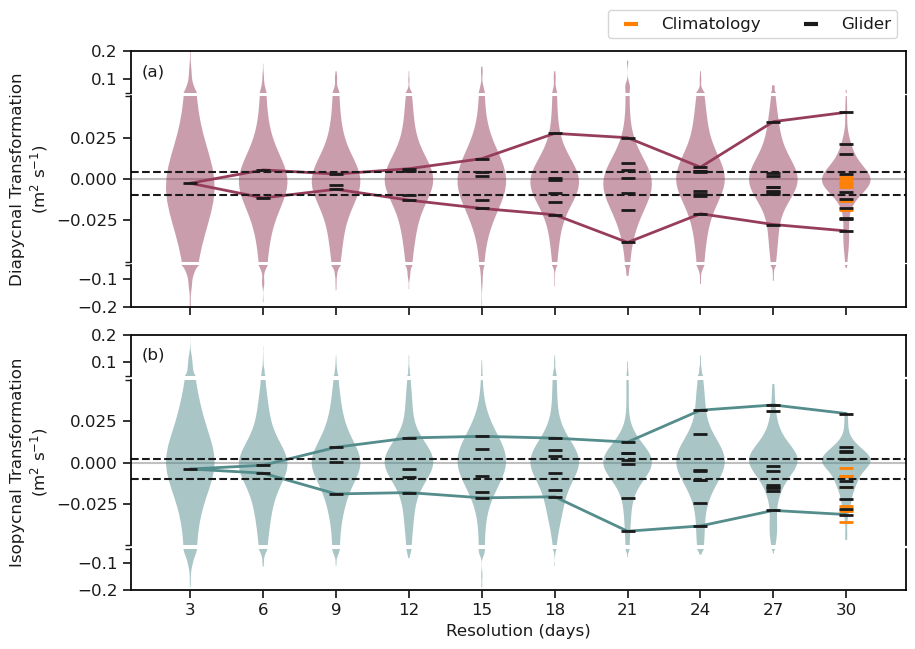

In [21]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

# Constants
res_days = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
res_labels = [f'{d}D' for d in res_days]
fntsize = 12

def make_violin(ax, x_pos, data, color):
    """Create violin plot with percentiles overlaid."""
    data_clean = data[~np.isnan(data)]
    if len(data_clean) == 0:
        return
    vp = ax.violinplot(data_clean, positions=[x_pos], widths=2,
                       showmeans=False, showextrema=False, showmedians=False)
    for body in vp['bodies']:
        body.set_alpha(0.5)
        body.set_facecolor(color)
        body.set_edgecolor('none')
    p20, p80 = np.nanpercentile(data_clean, [5, 95])
    ax.hlines([p20, p80], x_pos, x_pos, colors=color, linewidth=2)

def add_scatter_points(ax, subset_dict, color='k', alpha=1, marker='_'):
    """Scatter means from subset dictionary."""
    for x, (subset, count) in subset_dict.items():
        for i in range(count):
            mean_val = subset[i].mean(['T_bini', 'S_bini']).mean('time_mid')
            ax.scatter(x, mean_val, c=color, alpha=alpha, marker=marker,
                       edgecolor='none', linewidths=2, s=100, zorder=10000000)

def plot_main_panel(ax_top, ax_main, ax_bottom, variable, color, subset_dict,
                    max_arr, min_arr, max_arr2, min_arr2, argo_vals, label):
    for ax in [ax_top, ax_main, ax_bottom]:
        ax.axhline(0, c='silver', zorder=-10000)

    for ii, i in zip(res_days, res_labels):
        new_time = pd.date_range(start='2015-03-15', end='2015-07-01', freq=i)
        data_interp = glider_trans.sel(T_bini=slice(25, 25.25), S_bini=slice(4, 6.5))[variable]
        data_interp = data_interp.groupby_bins('time_mid', bins=new_time).mean()
        data_flat = data_interp.values.flatten()
        make_violin(ax_top, ii, data_flat, color)
        make_violin(ax_main, ii, data_flat, color)
        make_violin(ax_bottom, ii, data_flat, color)

    for ax in [ax_top, ax_main, ax_bottom]:
        add_scatter_points(ax, subset_dict, color='k')

    for ax in [ax_top, ax_main, ax_bottom]:
        # ax.plot(res_days, max_arr2, c='silver', linewidth=2)
        # ax.plot(res_days, min_arr2, c='silver', linewidth=2)
        ax.plot(res_days, max_arr, c=color, linewidth=2)
        ax.plot(res_days, min_arr, c=color, linewidth=2)
        ax.scatter(np.ones(len(argo_vals)) * 30, argo_vals, marker='_', linewidths=2,
                   c='#FF8000', s=100, zorder=1000)

    ax_top.set_ylim(0.05, 0.2)
    ax_top.spines['bottom'].set_visible(False)
    ax_top.set_xticks([])
    ax_top.set_yticks([0.1, 0.2])
    ax_top.set_yticks([0.05], minor=True)
    
    ax_main.set_ylim(-0.05, 0.05)
    ax_main.set_yticks([ -0.025, 0, 0.025])
    ax_main.set_yticks([-0.05, 0.05], minor=True)
    ax_main.set_xticks([])
    ax_main.spines['top'].set_visible(False)
    ax_main.spines['bottom'].set_visible(False)
    
    ax_bottom.set_ylim(-0.2, -0.05)
    ax_bottom.spines['top'].set_visible(False)
    ax_bottom.set_yticks([-0.1, -0.2])
    ax_bottom.set_yticks([-0.05], minor=True)
    
    ax_main.tick_params(axis='x', which='both', bottom=False, top=False)

    for ax in [ax_top, ax_main]:
        ax.tick_params(labelbottom=False)
    for ax in [ax_main, ax_bottom]:
        ax.set_xticks(res_days)


# Create figure with 2 rows (diapycnal and isopycnal), each with 3 sub-axes (top/main/bottom)
fig = plt.figure(figsize=(10, 7), constrained_layout=True)
gs = gridspec.GridSpec(7, 1, height_ratios=[1, 4, 1, 0.5, 1, 4, 1], hspace=0.05)

# Diapycnal panel
ax_dia_top = fig.add_subplot(gs[0])
ax_dia_main = fig.add_subplot(gs[1])
ax_dia_bot = fig.add_subplot(gs[2])

# Isopycnal panel
ax_iso_top = fig.add_subplot(gs[4])
ax_iso_main = fig.add_subplot(gs[5])
ax_iso_bot = fig.add_subplot(gs[6])

# Plotting panels (data assumed to be defined already)
plot_main_panel(ax_dia_top, ax_dia_main, ax_dia_bot, 'G_ti', c_diapy, t_subset_dict, max_t, min_t, max_s, min_s,
                argo_trans.sel(T_bini=slice(25, 25.25), S_bini=slice(4, 6.5)).G_ti.mean(['T_bini', 'S_bini']), '(a)')

plot_main_panel(ax_iso_top, ax_iso_main, ax_iso_bot, 'G_si', c_isopyc, s_subset_dict, max_s, min_s, max_t, min_t,
                argo_trans.sel(T_bini=slice(25, 25.25), S_bini=slice(4, 6.5)).G_si.mean(['T_bini', 'S_bini']), '(b)')

ax_dia_bot.set_xticklabels([])
# Legend (in top-most axis)
ax_dia_top.scatter([], [], marker='_', linewidths=3, c='#FF8000', s=100, label='Climatology')
ax_dia_top.scatter([], [], marker='_', linewidths=3, c='k', s=100, label='Glider')
ax_dia_top.legend(ncol=2, loc="upper right", fontsize=fntsize, bbox_to_anchor=(1,2.2))

ax_dia_main.axhline(gti_b_1std, c='k', ls='--')
ax_dia_main.axhline(gti_t_1std, c='k', ls='--')

ax_iso_main.axhline(gsi_b_1std, c='k', ls='--')
ax_iso_main.axhline(gsi_t_1std, c='k', ls='--')

# Optional: Tighten layout
# plt.show()
ax_iso_main.set_ylabel('Isopycnal Transformation\n(m$^{2}$ s$^{-1}$)', fontsize=fntsize)
ax_dia_main.set_ylabel('Diapycnal Transformation\n(m$^{2}$ s$^{-1}$)', fontsize=fntsize)
# ax_iso_main.set_xticks([])
ax_iso_bot.set_xlabel('Resolution (days)', fontsize=fntsize)

    # ax_main.text(1.8, 0.035, s=label, fontsize=fntsize)

ax_dia_top.tick_params(axis='both', labelsize=fntsize)
ax_dia_main.tick_params(axis='both', labelsize=fntsize)
ax_dia_bot.tick_params(axis='both', labelsize=fntsize)

ax_iso_top.tick_params(axis='both', labelsize=fntsize)
ax_iso_main.tick_params(axis='both', labelsize=fntsize)
ax_iso_bot.tick_params(axis='both', labelsize=fntsize)

ax_iso_top.text(1, 0.11, '(b)', fontsize=fntsize)
ax_dia_top.text(1, 0.11, '(a)', fontsize=fntsize)

plt.savefig('Fig3.png', dpi=600)


In [224]:
lower_bound=gsi_b_1std
upper_bound=gsi_t_1std
ass,bss=[],[]
for x, (subset, count) in s_subset_dict.items():
    NN=count
    apnd_=[]
    for i in range(count):
        mean_val = subset[i].mean(['T_bini', 'S_bini']).mean('time_mid').item()
        if lower_bound < mean_val < upper_bound:
            apnd_.append([0])
    MM=len(apnd_)
    ass.append(NN)
    bss.append(MM)

In [267]:
lower_bound=gti_b_1std
upper_bound=gti_t_1std
a,b=[],[]
for x, (subset, count) in t_subset_dict.items():
    NN=count
    apnd_=[]
    for i in range(count):
        mean_val = subset[i].mean(['T_bini', 'S_bini']).mean('time_mid').item()
        if lower_bound < mean_val < upper_bound:
            apnd_.append([0])
    MM=len(apnd_)
    a.append(NN)
    b.append(MM)

15.0


Text(0.5, 0, 'Resolution (days)')

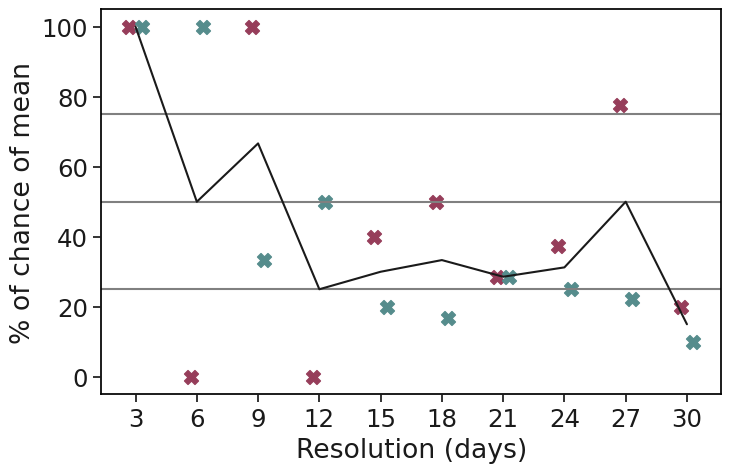

In [286]:
plt.figure(figsize=(8,5))
plt.scatter(np.arange(3,33,3)-0.3, np.array(b)*100/np.array(a), c=c_diapy, s=100, marker='X')
plt.scatter(np.arange(3,33,3)+0.3, np.array(bss)*100/np.array(ass), c=c_isopyc, s=100, marker='X')
plt.axhline(50, c='gray')
plt.axhline(25, c='gray')
plt.axhline(75, c='gray')

plt.plot(np.arange(3,33,3), np.nanmean([np.array(b)*100/np.array(a),  np.array(bss)*100/np.array(ass)], axis=0), c='k')
print(np.nanmean([np.array(b)*100/np.array(a),  np.array(bss)*100/np.array(ass)], axis=0)[-1])
plt.xticks(np.arange(3,33,3))
plt.ylabel('% of chance of mean')
plt.xlabel('Resolution (days)')


In [303]:
lower_bound=gti_b_1std
upper_bound=gti_t_1std
values=argo_trans.sel(T_bini=slice(25, 25.25), S_bini=slice(4, 6.5)).G_ti.mean(['T_bini', 'S_bini']).values[:-2]
a_climat=[]
for x in range(len(values)):
    mean_val = values[x]
    if lower_bound < mean_val < upper_bound:
        a_climat.append(0)

len(a_climat)*100/len(values)


60.0

In [304]:
lower_bound=gsi_b_1std
upper_bound=gsi_t_1std
values=argo_trans.sel(T_bini=slice(25, 25.25), S_bini=slice(4, 6.5)).G_si.mean(['T_bini', 'S_bini']).values[:-2]
a_climat=[]
for x in range(len(values)):
    mean_val = values[x]
    if lower_bound < mean_val < upper_bound:
        a_climat.append(0)

len(a_climat)*100/len(values)


40.0

In [302]:
argo_trans.sel(T_bini=slice(25, 25.25), S_bini=slice(4, 6.5)).G_si.mean(['T_bini', 'S_bini']).values[:-2]

array([-0.00791693, -0.00844809, -0.02929105, -0.01450544, -0.02604136])